In [226]:
%matplotlib inline

from collections import defaultdict
from datetime import datetime
import math
from glob import glob
import os
import statistics

import matplotlib.pyplot as plt
import pandas as pd
import tldextract
from cryptography import x509
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives import hashes

from pyspark.errors import *
import pyspark.sql.types as pst
import pyspark.sql.functions as psf
from pyspark.storagelevel import StorageLevel

In [61]:
%run ./spark-instance-gustavo.ipynb

SparkConf created
Started SparkSession
Spark version 3.5.0


In [60]:
clean_spark()

In [4]:
from ip_as_org import IPASnPrefix, ASOrg

def get_ip_asn_as_org_obj(timestamps):
    dates = [ts.strftime("%Y%m%d") for ts in timestamps]
    dataset_dir = "../dataset/"
    ip_asn = IPASnPrefix(dates, dataset_dir)
    as_org = ASOrg(dates, dataset_dir)
    return ip_asn, as_org

def ip_to_country(ip: str, when: str) -> str:
    asn = ip_asn.get_asn_from_ip(ip, when)
    if asn is None:
        return "Unknown"
    try:
        country = as_org.get_country_from_asn(asn, when)
    except ValueError:
        country = "Unknown"
    return country

def ip_to_org(ip: str, when: str) -> str:
    asn = ip_asn.get_asn_from_ip(ip, when)
    if asn is None:
        return "Unknown"
    try:
        org = as_org.get_org_name_from_asn(asn, when)
    except ValueError:
        org = "Unknown"
    return org


ip_to_country_udf = psf.udf(ip_to_country, pst.StringType())
ip_to_org_udf = psf.udf(ip_to_org, pst.StringType())

### Extracting Goscanner data

In [247]:
def eval_list_list_str(my_list):
    try:
        if isinstance(my_list, str):
            return eval(my_list)
        else:
            return [[]]
    except:
        return [[]]


eval_list_list_str_udf = psf.udf(eval_list_list_str, pst.ArrayType(pst.ArrayType(pst.StringType())))


def eval_list(my_list):
    try:
        if isinstance(my_list, str):
            return eval(my_list)
        else:
            return []
    except:
        return []


eval_udf = psf.udf(eval_list, pst.ArrayType(pst.IntegerType()))


def load_hosts_data(port, ts):
    hosts_base_path = HOSTS_PATH_FMT.format(port=port, year=ts.year, month=ts.month, day=ts.day)
    hosts_df = spark.read.option("header", "true") \
                         .option("lineSep", "\n") \
                         .option("quote", "\"") \
                         .option("escape", "\"") \
                         .option("inferSchema", "true") \
                         .csv(f"../dataset/{hosts_base_path}")
    return hosts_df


def load_certs_data(port, ts):
    certs_base_path = CERTS_PATH_FMT.format(port=port, year=ts.year, month=ts.month, day=ts.day)
    certs_df = spark.read.option("header", "true") \
                         .option("multiline", "true") \
                         .option("wholeFile", "true") \
                         .option("inferSchema", "true") \
                         .csv(f"../dataset/{certs_base_path}")
    return certs_df


def load_tls_data(port, ts):
    tls_base_path = TLS_PATH_FMT.format(port=port, year=ts.year, month=ts.month, day=ts.day)
    tls_df = spark.read.option("header", "true") \
                       .option("multiline", "true") \
                       .option("wholeFile", "true") \
                       .option("inferSchema", "true") \
                       .csv(f"../dataset/{tls_base_path}")
    return tls_df


def load_ldap_data(port, ts):
    ldap_base_path = LDAP_PATH_FMT.format(port=port, year=ts.year, month=ts.month, day=ts.day)
    ldap_df = spark.read.option("header", "true") \
                        .option("lineSep", "\n") \
                        .option("quote", "\"") \
                        .option("escape", "\"") \
                        .option("inferSchema", "true") \
                        .csv(f"../dataset/{ldap_base_path}")
    return ldap_df


def load_ldapstarttls_data(port, ts):
    starttls_base_path = STARTTLS_PATH_FMT.format(port=port, year=ts.year, month=ts.month, day=ts.day)
    starttls_df = spark.read.option("header", "true") \
                            .option("lineSep", "\n") \
                            .option("quote", "\"") \
                            .option("escape", "\"") \
                            .option("inferSchema", "true") \
                            .csv(f"../dataset/{starttls_base_path}")
    return starttls_df


def load_cert_validator(port, ts):
    cert_validator_base_path = CERTVAL_PATH_FMT.format(port=port, year=ts.year, month=ts.month, day=ts.day)
    df = spark.read.option("basePath", f"../dataset/{cert_validator_base_path}")\
                   .parquet(f"../dataset/{cert_validator_base_path}")
    return df


def convert_ldap_attributes(df):
    df = df.withColumn("asd", eval_list_list_str_udf(psf.col("attribute_names")))
    df = df.drop("attribute_names")
    df = df.withColumnRenamed("asd", "attribute_names")
    df = df.withColumn("qwe", eval_list_list_str_udf(psf.col("attribute_values_list")))
    df = df.drop("attribute_values_list")
    df = df.withColumnRenamed("qwe", "attribute_values_list")
    return df


def load_ldap_root_dse(port, ts):
    root_dse_base_path = ROOT_DSE_PATH_FMT.format(port=port, year=ts.year, month=ts.month, day=ts.day)
    df = spark.read.option("header", "true") \
                   .option("multiline", "true") \
                   .option("wholeFile", "true") \
                   .option("inferSchema", "true") \
                   .csv(f"../dataset/{root_dse_base_path}")

    df = convert_ldap_attributes(df)
    return df


def load_ldap_schema(port, ts):
    schema_base_path = SCHEMA_PATH_FMT.format(port=port, year=ts.year, month=ts.month, day=ts.day)
    df = spark.read.option("header", "true") \
                   .option("multiline", "true") \
                   .option("wholeFile", "true") \
                   .option("inferSchema", "true") \
                   .csv(f"../dataset/{schema_base_path}")

    df = convert_ldap_attributes(df)
    return df


def convert_output_df(df):
    df = df.select("id", "generic_error", psf.explode("root_stores").alias("store_name", "result"))
    df = df.select("id", "generic_error", "store_name", "result.*")
    df = df.withColumn("vc", eval_list_list_str_udf(psf.col("valid_chains")))
    df = df.drop("valid_chains")
    df = df.withColumnRenamed("vc", "valid_chains")
    return df


len_udf = psf.udf(lambda chain: [len(x) for x in chain], pst.ArrayType(pst.IntegerType()))


def chain_len(df):
    df = df.withColumn("chain_len", len_udf(psf.col("valid_chains")))
    df.select("chain_len").groupBy(psf.col("chain_len")).count().show()
    return df


def peer_certs_len(peer_certs_str):
    peer_certs = eval_list(peer_certs_str)
    return len(peer_certs)


peer_certs_len_udf = psf.udf(peer_certs_len, pst.IntegerType())

SHORT1 = "Signed by unknown authority"
SHORT2 = "Expired/Not yet valid"
SHORT3 = "Not authorized to sign other certificates"
SHORT4 = "Too many intermediate certificates"
SHORT5 = "Unhandled critical extension"
SHORT6 = "Other errors"
SHORT7 = "Self-signed"
SHORT8 = "Valid chain"
SHORT9 = "Invalid signature"  # under SHORT1


short_error_name_map = {
    'x509: certificate signed by unknown authority': SHORT1,
    'x509: certificate signed by unknown authority - With possible explanation': SHORT1,
    'x509: certificate has expired or is not yet valid': SHORT2,
    'x509: certificate is not authorized to sign other certificates': SHORT3,
    'x509: too many intermediates for path length constraint': SHORT4,
    'x509: unhandled critical extension': SHORT5,
    'x509: certificate signed by unknown authority (possibly because of "x509: invalid signature': SHORT9,
    '': SHORT8
}


def error_str(error_list, skid, akid, peer_certs_len):
    # test that all elements are empty
    if all(not element for element in error_list):
        return SHORT8

    # get the first non-empty error
    for error_data in error_list:
        if error_data != "":
            break

    parsed_error = ':'.join(error_data.split(":")[:3])
    if "certificate signed by unknown authority" in parsed_error:
        #if peer_certs_len == 1:
        if skid == "" or akid == "":
            if peer_certs_len == 1:
                return SHORT7
        elif skid == akid:
            return SHORT7

    error = short_error_name_map.get(parsed_error, None)
    if error is None:
        parsed_error = ':'.join(error_data.split(":")[:2])
        return short_error_name_map[parsed_error]
    return error


error_str_udf = psf.udf(error_str, pst.StringType())


# port 636 scans occurs one day earlier than port 389
PORT_SCANDATE_MAP = {
    636: [
        datetime(2023, 11, 7),
        datetime(2023, 11, 14),
        datetime(2023, 11, 21),
        datetime(2023, 11, 28)
    ],
    389: [
        datetime(2023, 11, 1),
        datetime(2023, 11, 8),
        datetime(2023, 11, 15),
        datetime(2023, 11, 22),
        datetime(2023, 11, 29)
    ]
}

HOSTS_PATH_FMT = "catrin/measurements/tool=goscanner/format=raw/port={port}/scan=tcp/result=hosts/year={year}/month={month:02d}/day={day:02d}"
CERTS_PATH_FMT = "catrin/measurements/tool=goscanner/format=raw/port={port}/scan=tls/result=certs/year={year}/month={month:02d}/day={day:02d}"
TLS_PATH_FMT = "catrin/measurements/tool=goscanner/format=raw/port={port}/scan=tls/result=tls_verbose/year={year}/month={month:02d}/day={day:02d}"
LDAP_PATH_FMT = "catrin/measurements/tool=goscanner/format=raw/port={port}/scan=ldap/result=ldap/year={year}/month={month:02d}/day={day:02d}"
STARTTLS_PATH_FMT = "catrin/measurements/tool=goscanner/format=raw/port={port}/scan=starttls_ldap/result=starttls_ldap/year={year}/month={month:02d}/day={day:02d}"
CERTVAL_PATH_FMT = "catrin/data_processing/tool=cert-validator/format=parquet/port={port}/year={year}/month={month:02d}/day={day:02d}"
SCHEMA_PATH_FMT = "catrin/measurements/tool=goscanner/format=raw/port={port}/scan=ldap_crawl/result=ldap_schema/year={year}/month={month:02d}/day={day:02d}"
ROOT_DSE_PATH_FMT = "catrin/measurements/tool=goscanner/format=raw/port={port}/scan=ldap_crawl/result=ldap_root_dse/year={year}/month={month:02d}/day={day:02d}"

goscanner_timestamps = []
for dates in PORT_SCANDATE_MAP.values():
    goscanner_timestamps.extend(dates)


ip_asn, as_org = get_ip_asn_as_org_obj(goscanner_timestamps)


tls_version_str_dict = {
    int("0x0301", 16): "TLSv1.0",
    int("0x0302", 16): "TLSv1.1",
    int("0x0303", 16): "TLSv1.2",
    int("0x0304", 16): "TLSv1.3",
    int("0x0300", 16): "SSLv3"
}


def tls_version_to_string(version_number: int):
    return tls_version_str_dict.get(version_number, str(version_number))


tls_version_udf = psf.udf(tls_version_to_string, pst.StringType())


def convert_cipher(x):
    try:
        parts = [int(part, 16) for part in x.split(",")]
    except ValueError:
        # to cover reserved values like 0x00,0x1C-1D
        return None
    cipher = parts[0] << 8
    cipher |= parts[1]
    return hex(cipher)[2:]


# https://www.iana.org/assignments/tls-parameters/tls-parameters.xhtml#tls-parameters-4
tls_parameters_pdf = pd.read_csv("tls-parameters-4.csv")
tls_parameters_pdf["Cipher"] = tls_parameters_pdf["Value"].apply(convert_cipher)
tls_parameters_pdf["DTLS-OK"] = tls_parameters_pdf["DTLS-OK"].apply(lambda x: str(x))
tls_parameters_pdf["Recommended"] = tls_parameters_pdf["Recommended"].apply(lambda x: str(x))
tls_parameters_pdf["Reference"] = tls_parameters_pdf["Reference"].apply(lambda x: str(x))
tls_parameter_dict = tls_parameters_pdf[["Cipher", "Description"]].set_index("Cipher").to_dict()["Description"]


def cipher_to_description(cipher):
    return tls_parameter_dict.get(cipher, "Unknown")


cipher_to_description_udf = psf.udf(cipher_to_description, pst.StringType())

In [150]:
# Decoding X.509 certificates
def get_x509(pem: str):
    return x509.load_pem_x509_certificate(str.encode(pem), default_backend())


def get_extensions(cert):
    tls_key_exchange = []
    san_list = []
    try:
        extensions = cert.extensions
        for extension in extensions:
            if isinstance(extension.value, x509.TLSFeature):
                tls_key_exchange.append(extension.value.key_exchange)
                continue
            if isinstance(extension.value, x509.SubjectAlternativeName):
                subject_alt_name = extension.value
                san_list += [name for name in subject_alt_name.get_values_for_type(x509.DNSName)]
                continue
    except:
        pass

    return tls_key_exchange, san_list


def get_x509_fields(pem: str):
    try:
        cert = get_x509(pem)
    except ValueError:
        # the certificate contains bytes that cannot be interpreted. Probably invalid cert
        # https://github.com/pyca/cryptography/issues/6804
        print(pem)
        return 6 * [None]  # CHANGE HERE IN CASE ADDITIONAL RETURN PARAMETER

    _, san_list = get_extensions(cert)

    public_key_size = None
    try:
        public_key_size = cert.public_key().key_size
    except AttributeError:
        #'cryptography.hazmat.bindings._rust.openssl.ed25519' object has no attribute 'key_size'
        pass

    cert_fp = cert.fingerprint(hashes.SHA256()).hex().upper()

    try:
        skid = cert.extensions.get_extension_for_oid(x509.oid.ExtensionOID.SUBJECT_KEY_IDENTIFIER).value.digest.hex().upper()
    except:
        pass
    akid = ""
    try:
        akid = cert.extensions.get_extension_for_oid(x509.oid.ExtensionOID.AUTHORITY_KEY_IDENTIFIER).value.key_identifier.hex().upper()
    except x509.oid.ExtensionOID.ExtensionNotFound:
        pass

    return (cert.signature_algorithm_oid._name,
            public_key_size,
            san_list,
            cert_fp,
            skid,
            akid
           )


pem_decoded_schema = pst.StructType([pst.StructField("tls_signature_algorithm", pst.StringType(), True),
                                 pst.StructField("pubkey_bit_size", pst.IntegerType(), True),
                                 pst.StructField("leaf_data_names", pst.ArrayType(pst.StringType()), True),  # SAN
                                 pst.StructField("fingerprint", pst.StringType(), True),
                                 pst.StructField("subject_key_identifier", pst.StringType(), True),
                                 pst.StructField("authority_key_identifier", pst.StringType(), True)
                                ])


decode_cert_udf = psf.udf(get_x509_fields, pem_decoded_schema)

Loading data extracted from the cluster

In [189]:
# data extracted using different notebook (ldap-dependency-goscanner-data-preparation.ipynb).
goscanner_df = spark.read.parquet(f"../dataset/catrin/ldap-dependency-2023Nov-goscanner.parquet")

goscanner_df = goscanner_df.withColumn("country", ip_to_country_udf(psf.col("ipv4"), psf.col("date")))
goscanner_df = goscanner_df.withColumn("org", ip_to_org_udf(psf.col("ipv4"), psf.col("date")))

self_signed_udf = psf.udf(lambda error_str: error_str == SHORT7, pst.BooleanType())
goscanner_df = goscanner_df.withColumn("error", error_str_udf(psf.col("root_store_error_list"), psf.col("peer_certs_len")))
goscanner_df = goscanner_df.withColumn("tls_signature_self_signed", self_signed_udf(psf.col("error")))

### Extracting Censys data

In [7]:
DATASET = "universal-internet-dataset"
CENSYS_BASE_PATH_FMT = "censys/dataset={dataset}/format=parquet"
CENSYS_PATH_FMT = os.path.join(CENSYS_BASE_PATH_FMT, "year={year}/month={month:02d}/day={day:02d}")

# Censys snapshot of 2022-Nov
timestamps = [
    datetime(2022, 11, 1),
    datetime(2022, 11, 8),
    datetime(2022, 11, 15),
    datetime(2022, 11, 22),
    datetime(2022, 11, 29),
]


def load_censys_data(ts):
    censys_base_path = CENSYS_PATH_FMT.format(dataset=DATASET, year=ts.year, month=ts.month, day=ts.day)
    try:
        censys_df = spark.read.option("basePath", f"../dataset/{censys_base_path}").parquet(f"../dataset/{censys_base_path}")
    except AnalysisException as e:
        print(e)
    return censys_df


def filter_df_by_label(df, ts, label: str):
    llabel = label.lower()

    ser_filtered_df = df.select('*').where((psf.array_contains(psf.col("service_names_list"), label.upper())))
    ser_filtered_df = ser_filtered_df.withColumn("filter_source", psf.lit("service_name"))

    if False:
        dns_filtered_df = df.select('*').filter(
            (psf.expr(f"exists(dns_names, x -> lower(x) like '%.{llabel}.%') or exists(dns_names, x -> lower(x) like '{llabel}.%')")) | 
            (psf.expr(f"exists(r_dns_names, x -> lower(x) like '%.{llabel}.%') or exists(r_dns_names, x -> lower(x) like '{llabel}.%')"))
        )
        dns_filtered_df = dns_filtered_df.withColumn("filter_source", psf.lit("dns_rdns"))

        filtered_df = ser_filtered_df.unionByName(dns_filtered_df)
        uniq_filtered_df = filtered_df.dropDuplicates(["ipv4"])
        uniq_filtered_df = uniq_filtered_df.withColumn("date", psf.lit(ts).cast(pst.TimestampType()))

    return ser_filtered_df


ip_asn, as_org = get_ip_asn_as_org_obj(timestamps)

In [18]:
CENSYS_TS_DICT = {}
for ts in timestamps:
    print(ts)
    _censys_df = load_censys_data(ts)

    select_df = _censys_df.select("host_identifier.ipv4",
                                 _censys_df.dns.names.alias("dns_names"),
                                 _censys_df.dns.reverse_dns.names.alias("r_dns_names"),
                                 "service_names_list",
                                 "services.port",
                                 _censys_df.services.tls.certificates.leaf_data.names.alias("leaf_data_names"),
                                 _censys_df.services.tls.version_selected.alias("tls_version"),
                                 _censys_df.services.tls.cipher_selected.alias("tls_cipher"),
                                 "services.tls.certificates.leaf_data.pubkey_bit_size",
                                 _censys_df.services.tls.certificates.leaf_data.signature.self_signed.alias("tls_signature_self_signed"),
                                 _censys_df.services.tls.certificates.leaf_data.signature.signature_algorithm.alias("tls_signature_algorithm"),
                                 _censys_df.services.tls.certificates.leaf_data.subject.common_name.alias("cert_cn"),
                                 _censys_df.services.tls.certificates.leaf_data.issuer.common_name.alias("issuer_cn")
                                )

    uniq_filtered_df = filter_df_by_label(select_df, ts, "ldap")

    when = ts.strftime("%Y%m%d")
    uniq_filtered_df = uniq_filtered_df.withColumn("country", ip_to_country_udf(psf.col("ipv4"), psf.lit(when)))
    uniq_filtered_df = uniq_filtered_df.withColumn("org", ip_to_org_udf(psf.col("ipv4"), psf.lit(when)))
    uniq_filtered_df = uniq_filtered_df.withColumn("date", psf.lit(ts).cast(pst.TimestampType()))

    CENSYS_TS_DICT[ts] = uniq_filtered_df
print("-------")

2022-11-01 00:00:00
2022-11-08 00:00:00
2022-11-15 00:00:00
2022-11-22 00:00:00
2022-11-29 00:00:00
-------


In [19]:
try:
    censys_compact_df.unpersist()
except:
    pass

dfs = [df for df in CENSYS_TS_DICT.values()]

censys_compact_df = dfs[0].unionByName(dfs[1])
for i in range(2, len(dfs)):
    censys_compact_df = censys_compact_df.unionByName(dfs[i])

censys_compact_df.persist()

DataFrame[ipv4: string, dns_names: array<string>, r_dns_names: array<string>, service_names_list: array<string>, port: array<bigint>, leaf_data_names: array<array<string>>, tls_version: array<string>, tls_cipher: array<string>, pubkey_bit_size: array<int>, tls_signature_self_signed: array<boolean>, tls_signature_algorithm: array<string>, cert_cn: array<array<string>>, issuer_cn: array<array<string>>, filter_source: string, country: string, org: string, date: timestamp]

#### Why not use Censys organization and country information?

In [21]:
# NOT REQUIRED TO RUN!
load_censys_data(ts).select("host_identifier.ipv4", "autonomous_system.organization", "autonomous_system.country_code").filter(psf.col("organization").isNotNull()).show()
censys_compact_df.select("ipv4", "org", "country", "date").filter(psf.col("date") == ts).show(3)

+----+------------+------------+
|ipv4|organization|country_code|
+----+------------+------------+
+----+------------+------------+

+--------------+--------------------+-------+-------------------+
|          ipv4|                 org|country|               date|
+--------------+--------------------+-------+-------------------+
|  84.237.80.54|Federal Research ...|     RU|2022-11-29 00:00:00|
| 189.230.16.99| Uninet S.A. de C.V.|     MX|2022-11-29 00:00:00|
|173.54.199.128|    Verizon Business|     US|2022-11-29 00:00:00|
+--------------+--------------------+-------+-------------------+
only showing top 3 rows



In [22]:
dfs = []
for df in CENSYS_TS_DICT.values():
    df2 = df.select("ipv4", "filter_source", "date", "country", "org",
                    psf.explode_outer(psf.arrays_zip(
                                        df.dns_names.alias("dns_name"),
                                        df.r_dns_names.alias("r_dns_name"),
                                        df.leaf_data_names.alias("leaf_data_name"),
                                        df.service_names_list.alias("service_name"),
                                        df.port.alias("port"),
                                        df.tls_version,
                                        df.tls_cipher,
                                        df.pubkey_bit_size,
                                        df.tls_signature_self_signed,
                                        df.tls_signature_algorithm,
                                        df.cert_cn,
                                        df.issuer_cn)))
    df2 = df2.select("ipv4", "filter_source", "date", "country", "org",
                     "col.dns_name", "col.r_dns_name", "col.leaf_data_name", "col.service_name", "col.port", "col.tls_version",
                     "col.tls_cipher", "col.pubkey_bit_size", "col.tls_signature_self_signed",
                     "col.tls_signature_algorithm", "col.cert_cn", "col.issuer_cn")

    # look these examples. There are 2 LDAP services for the same IP, there is ldap0.acc.umu.se in the dns_names, dns_names with one element (first) mapps to the first service name (probably right?)
    #df.filter((psf.col("ipv4") == "100.18.51.128") | (psf.col("ipv4") == "100.37.175.222") | (psf.col("ipv4") == "116.203.25.90") | (psf.col("ipv4") == "130.239.18.143")).select("ipv4", "filter_source", "dns_names", "service_names_list", "cert_cn").show(truncate=False)
    #df2.filter((psf.col("ipv4") == "100.18.51.128") | (psf.col("ipv4") == "100.37.175.222") | (psf.col("ipv4") == "116.203.25.90") | (psf.col("ipv4") == "130.239.18.143")).select("ipv4", "filter_source", "dns_name", "service_name", "cert_cn").show(truncate=False)

    if False:
        df2_filtered = df2.filter((psf.col("dns_name").like("%.ldap.%")) | (psf.col("dns_name").like("ldap.%")) | (psf.col("r_dns_name").like("%.ldap.%")) | (psf.col("r_dns_name").like("ldap.%")) | (psf.col("service_name") == "LDAP"))
    df2_filtered = df2.filter(psf.col("service_name") == "LDAP")

    #display(df2_filtered.count())  # 94997
    #display(df2_filtered.dropDuplicates(["ipv4"]).count())  # 74824
    dfs.append(df2_filtered)

censys_df = dfs[0].unionByName(dfs[1])
for i in range(2, len(dfs)):
    censys_df = censys_df.unionByName(dfs[i])

### X.509 analysis

In [151]:
dfs = []
for port, timestamps in PORT_SCANDATE_MAP.items():
    print(port)
    for ts in timestamps:
        print(ts)
        _hosts_df = load_hosts_data(port, ts)

        _hosts_df = _hosts_df.withColumnRenamed("id", "host_id")
        _hosts_df = _hosts_df.withColumnRenamed("ip", "ipv4")
        _hosts_df = _hosts_df.withColumnRenamed("cert_id", "hosts_cert_id")  # to use skid and akid
        _hosts_df = _hosts_df.select("host_id", "ipv4", "port", "peer_certificates", "hosts_cert_id")
        _hosts_df = _hosts_df.withColumn("peer_certs_len", peer_certs_len_udf(psf.col("peer_certificates"))).drop("peer_certificates")

        _certs_df = load_certs_data(port, ts)
        _certs_df = _certs_df.withColumnRenamed("id", "cert_id")
        _certs_df = _certs_df.withColumn("decoded_cert", decode_cert_udf(psf.col("cert"))).drop("cert", "system_cert_store").select("cert_id", "decoded_cert.*")

        _cert_val_df = load_cert_validator(port, ts)
        _cert_val_df = convert_output_df(_cert_val_df)

        _cert_val_df = _cert_val_df.groupby("id") \
                                     .agg(psf.collect_set("store_name").alias("store_name_list"),
                                          psf.collect_list("is_valid").alias("valid_list"),
                                          psf.collect_list("root_store_error").alias("root_store_error_list")
                                         )

        _cert_val_df = _cert_val_df.withColumn("date", psf.lit(ts).cast(pst.TimestampType()))

        _cert_val_hosts_df = _cert_val_df.join(_hosts_df, _cert_val_df.id == _hosts_df.host_id, "inner").drop("host_id")
        joined_df = _cert_val_hosts_df.join(_certs_df, _cert_val_hosts_df.hosts_cert_id == _certs_df.cert_id, "inner").drop("hosts_cert_id", "cert_id")
        joined_df = joined_df.withColumn("validation_error", error_str_udf(psf.col("root_store_error_list"),
                                                                           psf.col("subject_key_identifier"),
                                                                           psf.col("authority_key_identifier"),
                                                                           psf.col("peer_certs_len")
                                                                          ))
        #joined_df = _cert_val_hosts_df
        #joined_df = joined_df.withColumn("validation_error", error_str2_udf(psf.col("root_store_error_list"),
        #                                                                   psf.col("peer_certs_len")
        #                                                                  ))
        dfs.append(joined_df)


cert_val_df = dfs[0].unionByName(dfs[1])
for i in range(2, len(dfs)):
    cert_val_df = cert_val_df.unionByName(dfs[i])

636
2023-11-07 00:00:00
2023-11-14 00:00:00
2023-11-21 00:00:00
2023-11-28 00:00:00
389
2023-11-08 00:00:00
2023-11-15 00:00:00
2023-11-22 00:00:00
2023-11-29 00:00:00


Load data prepared

In [266]:
# file prepared with ldap-dependency-data-preparation.ipynb
cert_val_df = spark.read.parquet("../dataset/processing/2023-Nov-cert-validator-processing.parquet")

Generating the table

In [264]:
starttls_cert_val_df = cert_val_df.filter(psf.col("port") == 389) \
                                 .dropDuplicates(["ipv4"]) \
                                 .select("ipv4", "validation_error")
ldaps_cert_val_df = cert_val_df.filter(psf.col("port") == 636) \
                               .dropDuplicates(["ipv4"]) \
                               .select("ipv4", "validation_error")

inter_cert_val_df = starttls_cert_val_df.join(ldaps_cert_val_df.withColumnRenamed("validation_error", "b"), "ipv4", "inner").drop("b").filter(psf.col("ipv4").isNotNull())
display(inter_cert_val_df.count())
# starttls only
starttls_only_df = starttls_cert_val_df.subtract(ldaps_cert_val_df)
display(starttls_only_df.count())
# ldaps only
ldaps_only_df = ldaps_cert_val_df.subtract(starttls_cert_val_df)
display(ldaps_only_df.count())

33239

21164

187939

In [183]:
def cert_val_table(df):
    total = df.count()
    pdf = df.groupBy("validation_error").count().pandas_api()
    pdf["percentage"] = pdf["count"] / total * 100
    print("total: ", total)
    print(pdf.to_latex(index=False))
    display(pdf)

cert_val_table(starttls_only_df)
cert_val_table(ldaps_only_df)
cert_val_table(inter_cert_val_df)

total:  21164


/usr/local/spark/python/pyspark/pandas/frame.py:2606: FutureWarning: Argument `col_space` will be removed in 4.0.0.
  warnings.warn(


\begin{tabular}{lrr}
\toprule
validation_error & count & percentage \\
\midrule
Self-signed & 2523 & 11.921187 \\
Signed by unknown authority & 9952 & 47.023247 \\
Invalid signature & 50 & 0.236250 \\
Not authorized to sign other certificates & 24 & 0.113400 \\
Valid chain & 3436 & 16.235116 \\
Expired/Not yet valid & 5179 & 24.470799 \\
\bottomrule
\end{tabular}



,validation_error,count,percentage
0,Self-signed,2523,11.921187
1,Signed by unknown authority,9952,47.023247
2,Invalid signature,50,0.236250
3,Not authorized to sign other certificates,24,0.113400
4,Valid chain,3436,16.235116
5,Expired/Not yet valid,5179,24.470799


total:  187939


/usr/local/spark/python/pyspark/pandas/frame.py:2606: FutureWarning: Argument `col_space` will be removed in 4.0.0.
  warnings.warn(


\begin{tabular}{lrr}
\toprule
validation_error & count & percentage \\
\midrule
Self-signed & 6092 & 3.241477 \\
Signed by unknown authority & 63334 & 33.699232 \\
Invalid signature & 4 & 0.002128 \\
Not authorized to sign other certificates & 8 & 0.004257 \\
Valid chain & 110824 & 58.968069 \\
Unhandled critical extension & 4 & 0.002128 \\
Expired/Not yet valid & 7672 & 4.082176 \\
Too many intermediate certificates & 1 & 0.000532 \\
\bottomrule
\end{tabular}



,validation_error,count,percentage
0,Self-signed,6092,3.241477
1,Signed by unknown authority,63334,33.699232
2,Invalid signature,4,0.002128
3,Not authorized to sign other certificates,8,0.004257
4,Valid chain,110824,58.968069
5,Unhandled critical extension,4,0.002128
6,Expired/Not yet valid,7672,4.082176
7,Too many intermediate certificates,1,0.000532


total:  33239


/usr/local/spark/python/pyspark/pandas/frame.py:2606: FutureWarning: Argument `col_space` will be removed in 4.0.0.
  warnings.warn(


\begin{tabular}{lrr}
\toprule
validation_error & count & percentage \\
\midrule
Self-signed & 8245 & 24.805199 \\
Signed by unknown authority & 12757 & 38.379614 \\
Invalid signature & 7 & 0.021060 \\
Not authorized to sign other certificates & 8 & 0.024068 \\
Valid chain & 4413 & 13.276573 \\
Unhandled critical extension & 6 & 0.018051 \\
Expired/Not yet valid & 7803 & 23.475435 \\
\bottomrule
\end{tabular}



,validation_error,count,percentage
0,Self-signed,8245,24.805199
1,Signed by unknown authority,12757,38.379614
2,Invalid signature,7,0.021060
3,Not authorized to sign other certificates,8,0.024068
4,Valid chain,4413,13.276573
5,Unhandled critical extension,6,0.018051
6,Expired/Not yet valid,7803,23.475435


X.509 version

In [268]:
cert_val_df.groupBy("version").count().show()

+-------+-------+
|version|  count|
+-------+-------+
|   NULL|   1479|
|     v1|  20689|
|     v3|1016145|
+-------+-------+



Common Names in X.509 certs

In [269]:
cert_val_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- store_name_list: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- valid_list: array (nullable = true)
 |    |-- element: boolean (containsNull = true)
 |-- root_store_error_list: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- date: timestamp (nullable = true)
 |-- ipv4: string (nullable = true)
 |-- port: integer (nullable = true)
 |-- peer_certs_len: integer (nullable = true)
 |-- tls_signature_algorithm: string (nullable = true)
 |-- pubkey_bit_size: integer (nullable = true)
 |-- leaf_data_names: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- fingerprint: string (nullable = true)
 |-- subject_key_identifier: string (nullable = true)
 |-- authority_key_identifier: string (nullable = true)
 |-- subject_rdns: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- issuer_rdns: array (nullable = true)
 |    |-- element: string (contain

In [272]:
# https://ccadb.my.salesforce-sites.com/mozilla/IncludedCACertificateReportCSVFormat
ca_pdf = pd.read_csv("../dataset/processing/IncludedCACertificateReport.csv")
# https://ccadb.my.salesforce-sites.com/mozilla/IntermediateCertsSeparateAuditsCSV
intermediate_pdf = pd.read_csv("../dataset/processing/IntermediateCertsSeparateAuditsCSV.csv")

def get_x509_name(dn_list, fingerprint):
    # e.g.:
    # dn_list=[C=US, O=Let's Encrypt, CN=R3]
    # dn_list=[C=BE, O=GlobalSign nv-sa, CN=GlobalSign Atlas R3 DV TLS CA 2023 Q3]
    # TODO do we have organizations running many CAs? Who owns who?
    ca_name = None

    ca = ca_pdf[ca_pdf["SHA-256 Fingerprint"].str.contains(str(fingerprint), case=False) == True]["Owner"]
    if not ca.empty:
        ca_name = ca.iloc[0]
    if ca_name is None:
        inter = intermediate_pdf[intermediate_pdf["SHA-256 Fingerprint"].str.contains(str(fingerprint), case=False) == True]["Certificate Name"]
        if not inter.empty:
            ca_name = inter.iloc[0]

    if dn_list:
        if ca_name is None:
            for dn in dn_list:
                if "CN=" in dn:
                    ca_name = dn.split("=")[-1]
                    break

        if ca_name is None:
            for dn in dn_list:
                if "O=" in dn:  # group with CN
                    ca_name = dn.split("=")[-1]
                    break

        if ca_name is None:
            for dn in dn_list:
                if "OU=" in dn:
                    ca_name = dn.split("=")[-1]
                    break

    return ca_name


get_x509_name_udf = psf.udf(get_x509_name, pst.StringType())

In [270]:
cert_val_df = cert_val_df.withColumn("")

+----------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------+
|subject_rdns                                                                      |issuer_rdns                                                                                      |
+----------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------+
|[CN=imperva.com]                                                                  |[C=BE, O=GlobalSign nv-sa, CN=GlobalSign Atlas R3 DV TLS CA 2023 Q3]                             |
|[CN=imperva.com]                                                                  |[C=BE, O=GlobalSign nv-sa, CN=GlobalSign Atlas R3 DV TLS CA 2023 Q3]                             |
|[CN=imperva.com]                                                                  |[

Below X.509 is not used

In [107]:
def percentage(cnt, port, total_389, total_636):
    if port == 389:
        return cnt / total_389 * 100
    return cnt / total_636 * 100

cert_val_pdf = cert_val_df.groupBy(["validation_error", "port"]).count().toPandas()
total_636 = cert_val_pdf[cert_val_pdf["port"] == 636]["count"].sum()
total_389 = cert_val_pdf[cert_val_pdf["port"] == 389]["count"].sum()
cert_val_pdf["percentage"] = cert_val_pdf.apply(lambda x: percentage(x["count"], x["port"], total_389, total_636), axis=1)
cert_val_pdf = cert_val_pdf.sort_values(["port", "count"], ascending=False)
display(cert_val_pdf.to_latex(index=False))
display(cert_val_pdf)
print(total_636, total_389)

'\\begin{tabular}{lrrr}\n\\toprule\nvalidation_error & port & count & percentage \\\\\n\\midrule\nSelf-signed & 389 & 12517 & 30.623379 \\\\\nSigned by unknown authority & 389 & 11974 & 29.294906 \\\\\nExpired/Not yet valid & 389 & 9416 & 23.036649 \\\\\nValid chain & 389 & 6885 & 16.844449 \\\\\nInvalid signature & 389 & 55 & 0.134560 \\\\\nNot authorized to sign other certificates & 389 & 22 & 0.053824 \\\\\nUnhandled critical extension & 389 & 5 & 0.012233 \\\\\n\\bottomrule\n\\end{tabular}\n'

,validation_error,port,count,percentage
3,Self-signed,389,12517,30.623379
5,Signed by unknown authority,389,11974,29.294906
4,Expired/Not yet valid,389,9416,23.036649
6,Valid chain,389,6885,16.844449
0,Invalid signature,389,55,0.134560
2,Not authorized to sign other certificates,389,22,0.053824
1,Unhandled critical extension,389,5,0.012233


0 40874


### Hosts analysis

In [25]:
def process_hosts(df, dataset: str):
    df.persist()

    print("Processing LDAP hosters")
    # ldap_hoster_pdf = df.select("ipv4", "date").toPandas().value_counts().reset_index()
    ldap_hoster_pdf = df.select("ipv4", "date").groupBy("date").count().coalesce(1).pandas_api()
    ldap_hoster_pdf.to_csv(f"../dataset/processing/{dataset}_date_ldap_hosts")
    #ldap_hoster_pdf.value_counts("date").to_csv(f"../dataset/processing/{dataset}_date_ldap_hosts")

    df.unpersist()

In [26]:
print("Processing Censys CUIDS")
process_hosts(censys_df, "censys")

print("Processing GoScanner")
process_hosts(goscanner_df, "goscanner")

Processing Censys CUIDS
Processing LDAP hosters


/usr/local/spark/python/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(
/usr/local/spark/python/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Processing GoScanner
Processing LDAP hosters


In [39]:
censys_df.filter(psf.col("ipv4") == "202.61.243.75").select("dns_name", "r_dns_name", "leaf_data_name").filter(psf.col("dns_name").isNotNull()).filter(psf.col("r_dns_name").isNotNull()).show(3, truncate=False)

+--------+----------+--------------+
|dns_name|r_dns_name|leaf_data_name|
+--------+----------+--------------+
+--------+----------+--------------+



In [ ]:
censys_df.filter(psf.col("ipv4") == "202.61.243.75").show()

In [36]:
censys_compact_df.select("ipv4", "dns_names", "r_dns_names", "leaf_data_names").filter(psf.col("dns_names").isNotNull()).filter(psf.col("r_dns_names").isNotNull()).show(10, truncate=False)

+---------------+------------------------------------------------------------------------------------------+----------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ipv4           |dns_names                                                                                 |r_dns_names                                                     |leaf_data_names                                                                                                                                                                                                   

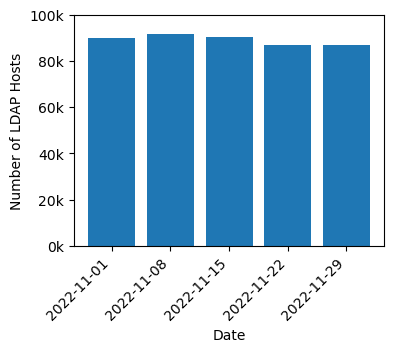

In [226]:
# UNUSED
aggr_ldap_hoster_pdf = pd.concat([pd.read_csv(filename, parse_dates=True) for filename in glob("../dataset/processing/censys_date_ldap_hosts/*csv")])

fig, ax = plt.subplots(figsize=(4,3))  # Adjust the width and height as desired
ax.bar(aggr_ldap_hoster_pdf['date'], aggr_ldap_hoster_pdf['count'])
ax.set_xlabel('Date')
xlabels = [datetime.fromisoformat(label.get_text()).strftime('%Y-%m-%d') for label in ax.get_xticklabels()]
ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels(xlabels, rotation=45, ha='right') 
# change y ticks to show in k
yticks = np.array([int(item.get_text()) for item in ax.get_yticklabels()])
ylabels = [f'{int(item.get_text())/1000:.0f}k' for item in ax.get_yticklabels()]
ax.set_yticks(yticks)
ax.set_yticklabels(ylabels)
ax.set_ylabel('Number of LDAP Hosts')
#ax.set_title('Number of LDAP Hosts')
fig.savefig("output/ldap_hosts.pdf", dpi=300, bbox_inches='tight')
fig.show()

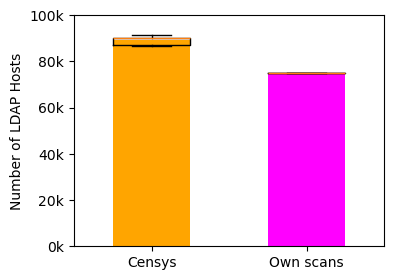

In [338]:
censys_aggr_ldap_hoster_pdf = pd.concat([pd.read_csv(filename, parse_dates=True) for filename in glob("../dataset/processing/censys_date_ldap_hosts/*csv")])
goscanner_ldap_hoster_pdf = pd.concat([pd.read_csv(filename, parse_dates=True) for filename in glob("../dataset/processing/goscanner_date_ldap_hosts/*csv")]).sort_values("date").iloc[1:]  # removing first line that came from previous snapshot (not a 636-389 pair)
even = goscanner_ldap_hoster_pdf.iloc[1::2]  # port 636
odd = goscanner_ldap_hoster_pdf.iloc[::2]  # port 389
goscanner_aggr_ldap_hoster_pdf = even["count"].to_numpy() + odd["count"].to_numpy()

fig, ax = plt.subplots(figsize=(4,3))  # Adjust the width and height as desired
ax.bar([1, 2], [statistics.mean(censys_aggr_ldap_hoster_pdf['count']), statistics.mean(goscanner_aggr_ldap_hoster_pdf)], color=['orange', 'magenta'], width=0.5)
ax.boxplot([censys_aggr_ldap_hoster_pdf['count'], goscanner_aggr_ldap_hoster_pdf], positions=[1, 2], widths=0.5)
ax.set_xticks([1, 2])
ax.set_xticklabels(["Censys", "Own scans"])
ax.set_ylabel('Number of LDAP Hosts')
#ax.set_title('Average number of LDAP Hosts')
yticks = np.array([int(item.get_text()) for item in ax.get_yticklabels()])
ylabels = [f'{int(item.get_text())/1000:.0f}k' for item in ax.get_yticklabels()]
ax.set_yticks(yticks)
ax.set_yticklabels(ylabels)
fig.savefig("output/ldap_hosts.pdf", dpi=300, bbox_inches='tight')
fig.show()

### TLS Analysis

In [252]:
def process_tls(df, dataset: str):
    df.persist()

    print("Processing TLS versions")
    tls_versions_df = df.filter((psf.col("tls_version").isNotNull()) & (psf.col("tls_version") != "")).groupBy("tls_version").count()
    tls_version_pdf = tls_versions_df.coalesce(1).pandas_api().sort_values("tls_version", ascending=False)
    total = tls_version_pdf["count"].sum()
    tls_version_pdf["percentage"] = tls_version_pdf["count"] / total * 100
    tls_version_pdf.to_csv(f"../dataset/processing/{dataset}_tls_version", index=False)

    print("Processing Ciphersuites")
    ciphers_df = df.filter((psf.col("tls_cipher").isNotNull()) & (psf.col("tls_cipher") != "")).groupBy("tls_cipher").count()
    ciphers_pdf = ciphers_df.coalesce(1).pandas_api().sort_values("count", ascending=False)
    #aggr_ciphers_pdf = ciphers_pdf.groupby("tls_cipher").sum().reset_index().sort_values("count", ascending=False)
    total = ciphers_pdf["count"].sum()
    ciphers_pdf["percentage"] = ciphers_pdf["count"] / total * 100
    ciphers_pdf.to_csv(f"../dataset/processing/{dataset}_all_ciphers", index=False)

    print("Processing Signature algorithms")
    tls_sign_algo_df = df.filter((psf.col("tls_signature_algorithm").isNotNull()) & (psf.col("tls_signature_algorithm") != "")).groupBy("tls_signature_algorithm").count()
    tls_sign_algo_pdf = tls_sign_algo_df.coalesce(1).pandas_api().sort_values("count", ascending=False)
    #aggr_tls_sign_algo_pdf = tls_sign_algo_pdf.groupby("tls_signature_algorithm").sum().reset_index().sort_values("count", ascending=False)
    total = tls_sign_algo_pdf["count"].sum()
    tls_sign_algo_pdf["percentage"] = tls_sign_algo_pdf["count"] / total * 100
    tls_sign_algo_pdf.to_csv(f"../dataset/processing/{dataset}_tls_sign_algo", index=False)

    print("Processing Self-signed certificates")
    tls_self_signed_df = df.filter((psf.col("tls_signature_self_signed").isNotNull())).groupBy("tls_signature_self_signed").count()
    tls_self_signed_pdf = tls_self_signed_df.coalesce(1).pandas_api().sort_values("count", ascending=False)
    #aggr_tls_self_signed_pdf = tls_self_signed_pdf.groupby("tls_signature_self_signed").sum().sort_values("count", ascending=False)
    total = tls_self_signed_pdf["count"].sum()
    tls_self_signed_pdf["percentage"] = tls_self_signed_pdf["count"] / total * 100
    tls_self_signed_pdf.to_csv(f"../dataset/processing/{dataset}_tls_self_signed", index=False)

    if False:
        # unused rfc recommendation code...
        tls_df = df.filter(psf.col("pubkey_bit_size").isNotNull()) \
                   .filter((psf.col("tls_cipher").isNotNull()) & (psf.col("tls_cipher") != "")) \
                   .filter((psf.col("tls_version").isNotNull()) & (psf.col("tls_version") != "")) \
                   .groupBy("tls_cipher", "tls_version", "pubkey_bit_size", "date").count()
        tls_pdf = tls_df.toPandas().to_csv(f"../dataset/processing/{dataset}_tls.csv", index=False)

    df.unpersist()

In [253]:
print("Processing Censys CUIDS")
process_tls(censys_df, "censys")

print("Processing GoScanner")
process_tls(goscanner_df, "goscanner")

Processing Censys CUIDS
Processing TLS versions


/usr/local/spark/python/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Processing Self-signed certificates


/usr/local/spark/python/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Processing GoScanner
Processing TLS versions


/usr/local/spark/python/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Processing Self-signed certificates


/usr/local/spark/python/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [271]:
censys_aggr_tls_version_pdf = pd.concat([pd.read_csv(filename) for filename in glob("../dataset/processing/censys_tls_version/*csv")])
print("Censys")
display(censys_aggr_tls_version_pdf)
print("GoScanner")
goscanner_aggr_tls_version_pdf = pd.concat([pd.read_csv(filename) for filename in glob("../dataset/processing/goscanner_tls_version/*csv")])
display(goscanner_aggr_tls_version_pdf)

Censys


,tls_version,count,percentage
0,TLSv1_3,39162,29.066591
1,TLSv1_2,88980,66.042217
2,TLSv1_1,682,0.506190
3,TLSv1_0,5908,4.385001


GoScanner


,tls_version,count,percentage
0,TLSv1.3,121559,35.959307
1,TLSv1.2,203679,60.251859
2,TLSv1.1,900,0.266236
3,TLSv1.0,11908,3.522598


In [260]:
print("Censys")
censys_aggr_ciphers_pdf = pd.concat([pd.read_csv(filename) for filename in glob("../dataset/processing/censys_all_ciphers/*csv")])
display(censys_aggr_ciphers_pdf.sort_values("tls_cipher", ascending=False))

print("GoScanner")
goscanner_aggr_ciphers_pdf = pd.concat([pd.read_csv(filename) for filename in glob("../dataset/processing/goscanner_all_ciphers/*csv")])
display(goscanner_aggr_ciphers_pdf.sort_values("tls_cipher", ascending=False))

Censys


,tls_cipher,count,percentage
9,TLS_RSA_WITH_AES_256_GCM_SHA384,2626,1.949054
12,TLS_RSA_WITH_AES_256_CBC_SHA,832,0.617522
2,TLS_RSA_WITH_AES_128_GCM_SHA256,18658,13.848232
7,TLS_RSA_WITH_AES_128_CBC_SHA,5028,3.731853
11,TLS_RSA_WITH_3DES_EDE_CBC_SHA,883,0.655375
6,TLS_ECDHE_RSA_WITH_CHACHA20_POLY1305_SHA256,5904,4.382032
0,TLS_ECDHE_RSA_WITH_AES_256_GCM_SHA384,32555,24.162782
4,TLS_ECDHE_RSA_WITH_AES_256_CBC_SHA,15440,11.459787
5,TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256,12022,8.922899
10,TLS_ECDHE_RSA_WITH_AES_128_CBC_SHA,974,0.722917


GoScanner


,tls_cipher,count,percentage
9,TLS_RSA_WITH_AES_256_GCM_SHA384,3927,1.161676
13,TLS_RSA_WITH_AES_256_CBC_SHA,1323,0.391367
0,TLS_RSA_WITH_AES_128_GCM_SHA256,69831,20.657248
7,TLS_RSA_WITH_AES_128_CBC_SHA,10586,3.131526
12,TLS_RSA_WITH_3DES_EDE_CBC_SHA,1388,0.410595
8,TLS_ECDHE_RSA_WITH_CHACHA20_POLY1305_SHA256,10431,3.085675
1,TLS_ECDHE_RSA_WITH_AES_256_GCM_SHA384,69222,20.477095
4,TLS_ECDHE_RSA_WITH_AES_256_CBC_SHA,27055,8.003349
5,TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256,18461,5.461091
10,TLS_ECDHE_RSA_WITH_AES_128_CBC_SHA,1860,0.550221


In [259]:
# https://owasp.org/www-chapter-london/assets/slides/OWASPLondon20180125_TLSv1.3_Andy_Brodie.pdf
# TLSv1.3:
# key exchange: ECDHE, DHE, PSK and, PSK-DHE (PSK for resumption)
# authentication (digital signature - uses X.509 cert): RSA, EdDSA or ECDSA. (Rivest-Shamir-Addleman, Edwards-curve Digital Signature Algorithm, Elliptic Curve Digital Signature Algorithm)
# See also https://datatracker.ietf.org/doc/html/rfc8446#section-1 for authentication
cipher_mapping = {
    # 'cipher_name' : ('key_exchange', 'authentication', 'encryption', 'hash', 'weak')
    'TLS_CHACHA20_POLY1305_SHA256': ('(EC)DHE/PSK', 'RSA/ECDSA/EdDSA', 'CHACHA20_POLY1305', 'SHA256', False),
    'TLS_AES_256_GCM_SHA384': ('(EC)DHE/PSK','RSA/ECDSA/EdDSA','AES_256_GCM','SHA384', False),
    'TLS_AES_128_GCM_SHA256': ('(EC)DHE/PSK','RSA/ECDSA/EdDSA','AES_128_GCM','SHA256', False),

    'TLS_ECDHE_RSA_WITH_CHACHA20_POLY1305_SHA256': ('ECDHE','RSA','CHACHA20_POLY1305','SHA256', False),
    'TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256': ('ECDHE','RSA','AES_128_GCM','SHA256', False),
    'TLS_ECDHE_RSA_WITH_AES_256_GCM_SHA384': ('ECDHE','RSA','AES_256_GCM','SHA384', False),
    'TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256': ('ECDHE','ECDSA','AES_128_GCM','SHA256', False),
    'TLS_ECDHE_ECDSA_WITH_AES_256_GCM_SHA384': ('ECDHE','ECDSA','AES_256_GCM','SHA384', False),
    'TLS_ECDHE_ECDSA_WITH_CHACHA20_POLY1305_SHA256': ('ECDHE','ECDSA','CHACHA20_POLY1305','SHA256', False),

    'TLS_ECDHE_ECDSA_WITH_AES_128_CBC_SHA': ('ECDHE','ECDSA','AES_128_CBC','SHA', True),
    'TLS_ECDHE_ECDSA_WITH_AES_256_CBC_SHA': ('ECDHE','ECDSA','AES_256_CBC','SHA', True),
    'TLS_ECDHE_RSA_WITH_AES_256_CBC_SHA': ('ECDHE','RSA','AES_256_CBC','SHA', True),
    'TLS_ECDHE_RSA_WITH_AES_128_CBC_SHA': ('ECDHE','RSA','AES_128_CBC','SHA', True),
    'TLS_ECDHE_RSA_WITH_3DES_EDE_CBC_SHA': ('ECDHE','RSA','3DES_EDE_CBC','SHA', True),
    'TLS_RSA_WITH_AES_128_GCM_SHA256': ('RSA','RSA','AES_128_GCM','SHA256', True),
    'TLS_RSA_WITH_AES_256_GCM_SHA384': ('RSA','RSA','AES_256_GCM','SHA384', True),
    'TLS_RSA_WITH_AES_256_CBC_SHA': ('RSA','RSA','AES_256_CBC','SHA', True),
    'TLS_RSA_WITH_AES_128_CBC_SHA': ('RSA','RSA','AES_128_CBC','SHA', True),
    'TLS_RSA_WITH_3DES_EDE_CBC_SHA': ('RSA','RSA','3DES_EDE_CBC','SHA', True),
    # Add more mappings for other non-standard cipher strings if needed
}

def parse_tls_cipher(pdf):
    cipher = pdf['tls_cipher']
    try:
        tls_key_exchange, tls_authentication, tls_encryption, tls_hash, tls_weak = cipher_mapping[cipher]
    except KeyError:
        print(f"Unknown cipher: {cipher}")
        raise
    pdf['cipher_key_exchange'] = tls_key_exchange
    pdf['cipher_authentication'] = tls_authentication
    pdf['cipher_encryption'] = tls_encryption
    pdf['cipher_hash'] = tls_hash
    pdf['cipher_weak'] = tls_weak
    return pdf

In [262]:
def show_cipher_ks(aggr_ciphers_pdf):
    aggr_ciphers_pdf = aggr_ciphers_pdf.apply(parse_tls_cipher, axis=1)
    encryption_pdf = aggr_ciphers_pdf.groupby("cipher_encryption").sum().reset_index().sort_values("count", ascending=False)[["cipher_encryption", "count", "percentage"]]
    display(encryption_pdf)
    key_exchange_pdf = aggr_ciphers_pdf.groupby("cipher_key_exchange").sum().reset_index().sort_values("count", ascending=False)[["cipher_key_exchange", "count", "percentage"]]
    display(key_exchange_pdf)

# TODO call this function with different aggr_ciphers_pdf (censys and goscanner)
print("Censys")
show_cipher_ks(censys_aggr_ciphers_pdf)

print("GoScanner")
show_cipher_ks(goscanner_aggr_ciphers_pdf)

Censys


,cipher_encryption,count,percentage
4,AES_256_GCM,54911,40.755722
2,AES_128_GCM,34247,25.418609
5,CHACHA20_POLY1305,22417,16.638215
3,AES_256_CBC,16272,12.077309
1,AES_128_CBC,6002,4.454769
0,3DES_EDE_CBC,883,0.655375


,cipher_key_exchange,count,percentage
1,ECDHE,67543,50.131372
0,(EC)DHE/PSK,39162,29.066591
2,RSA,28027,20.802037


GoScanner


,cipher_encryption,count,percentage
4,AES_256_GCM,121081,35.817906
2,AES_128_GCM,106267,31.435663
5,CHACHA20_POLY1305,68486,20.259373
3,AES_256_CBC,28378,8.394716
1,AES_128_CBC,12446,3.681747
0,3DES_EDE_CBC,1388,0.410595


,cipher_key_exchange,count,percentage
1,ECDHE,129432,38.288280
0,(EC)DHE/PSK,121559,35.959307
2,RSA,87055,25.752412


In [266]:
# SHA256-RSAPSS, RSASSA-PSS:
# https://www.cryptsoft.com/pkcs11doc/v230/group__SEC__11__1__17__PKCS____1__RSA__PSS__SIGNATURE__WITH__SHA__1____SHA__256____SHA__384__OR__SHA__512.html
# https://crypto.stackexchange.com/questions/58680/whats-the-difference-between-rsa-pss-pss-and-rsa-pss-rsae-schemes
# https://crypto.stackexchange.com/questions/48407/should-i-be-using-pkcs1-v1-5-or-pss-for-rsa-signatures
sign_algo_x509_to_censys = {
    "sha256WithRSAEncryption": "SHA256-RSA",
    "sha1WithRSAEncryption": "SHA1-RSA",
    "sha384WithRSAEncryption": "SHA384-RSA",
    "sha512WithRSAEncryption": "SHA512-RSA",
    "ecdsa-with-SHA384": "ECDSA-SHA384",
    "md5WithRSAEncryption": "MD5-RSA",
    "ecdsa-with-SHA256": "ECDSA-SHA256",
    "Unknown OID": "Unknown OID",
    "RSASSA-PSS": "SHA1-RSAPSS",
    "ecdsa-with-SHA512": "ECDSA-SHA512",
    "ecdsa-with-SHA1": "ECDSA-SHA1"
}

In [272]:
# https://www.alvestrand.no/objectid/submissions/2.16.840.1.101.3.4.3.16.html
# 2.16.840.1.101.3.4.3.16 = SHA-3-512 with RSA Encryption
print("Censys")
censys_aggr_tls_sign_algo_pdf = pd.concat([pd.read_csv(filename) for filename in glob("../dataset/processing/censys_tls_sign_algo/*csv")])
display(censys_aggr_tls_sign_algo_pdf)
print("GoScanner")
goscanner_aggr_tls_sign_algo_pdf = pd.concat([pd.read_csv(filename) for filename in glob("../dataset/processing/goscanner_tls_sign_algo/*csv")])
goscanner_aggr_tls_sign_algo_pdf["mapped"] = goscanner_aggr_tls_sign_algo_pdf["tls_signature_algorithm"].map(sign_algo_x509_to_censys)
display(goscanner_aggr_tls_sign_algo_pdf[["mapped", "count", "percentage"]])


Censys


,tls_signature_algorithm,count,percentage
0,SHA256-RSA,103396,76.741977
1,SHA1-RSA,26559,19.712466
2,SHA384-RSA,1901,1.410949
3,SHA512-RSA,1263,0.937417
4,MD5-RSA,736,0.546270
5,ECDSA-SHA384,565,0.419351
6,ECDSA-SHA256,258,0.191491
7,SHA256-RSAPSS,24,0.017813
8,ECDSA-SHA512,20,0.014844
9,2.16.840.1.101.3.4.3.16,5,0.003711


GoScanner


,mapped,count,percentage
0,SHA256-RSA,256858,76.161136
1,SHA1-RSA,68139,20.203940
2,SHA384-RSA,4770,1.414356
3,SHA512-RSA,3140,0.931043
4,ECDSA-SHA384,2108,0.625044
5,MD5-RSA,1132,0.335650
6,ECDSA-SHA256,877,0.260040
7,Unknown OID,106,0.031430
8,SHA1-RSAPSS,99,0.029355
9,ECDSA-SHA512,19,0.005634


In [273]:
print("Censys")
censys_aggr_tls_self_signed_pdf = pd.concat([pd.read_csv(filename) for filename in glob("../dataset/processing/censys_tls_self_signed/*csv")])
display(censys_aggr_tls_self_signed_pdf)
print("GoScanner")
goscanner_aggr_tls_self_signed_pdf = pd.concat([pd.read_csv(filename) for filename in glob("../dataset/processing/goscanner_tls_self_signed/*csv")])
display(goscanner_aggr_tls_self_signed_pdf)

Censys


,tls_signature_self_signed,count,percentage
0,False,104620,77.650447
1,True,30112,22.349553


GoScanner


,tls_signature_self_signed,count,percentage
0,False,229106,67.773617
1,True,108940,32.226383


What are the organizations that are fostering tlsv1.3?

In [198]:
tlsv3_org_pdf = goscanner_df.filter(psf.col("tls_version") == "TLSv1.3").groupBy("org").count().sort("count", ascending=False).toPandas()

In [199]:
total = tlsv3_org_pdf["count"].sum()
tlsv3_org_pdf["percentage"] = tlsv3_org_pdf["count"] / total * 100
display(tlsv3_org_pdf.head(10))

,org,count,percentage
0,"Amazon.com, Inc.",10352,8.516029
1,Hetzner Online GmbH,7244,5.959246
2,Iway AG,6028,4.958909
3,OVH SAS,5034,4.141199
4,Contabo GmbH,2180,1.793368
5,Deutsche Telekom AG,2039,1.677375
6,"Chunghwa Telecom Co., Ltd.",1646,1.354075
7,"DigitalOcean, LLC",1624,1.335977
8,netcup GmbH,1395,1.147591
9,"Akamai Technologies, Inc.",1286,1.057922


3400


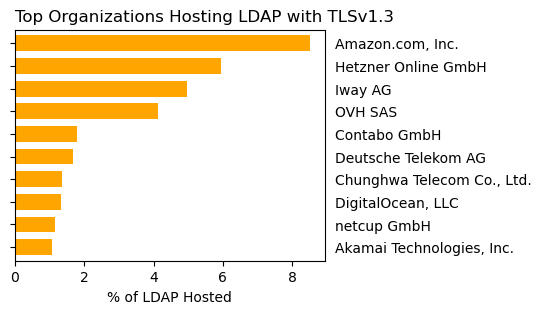

In [258]:
print(len(tlsv3_org_pdf))
top_10tlsv3_org = tlsv3_org_pdf.head(10)[["org", "percentage"]].set_index("org")

width = 0.7
ax1 = top_10tlsv3_org.plot.barh(width=width, color=['orange'], figsize=(4,3), legend=False)
ax1.invert_yaxis()
ax1.set_title('Top Organizations Hosting LDAP with TLSv1.3', loc='left')
ax1.tick_params(axis='y', labelright=True, labelleft=False)  
ax1.set_xlabel('% of LDAP Hosted')
ax1.set_ylabel(None)
fig = ax1.get_figure()
fig.savefig("output/ldap_tlsv3_org.pdf", dpi=300, bbox_inches='tight')
fig.show()

In [275]:
def show_total(aggr_tls_sign_algo_pdf, aggr_ciphers_pdf, aggr_tls_self_signed_pdf, aggr_tls_version_pdf):
    # all should match
    s = aggr_tls_sign_algo_pdf["count"].sum()
    c = aggr_ciphers_pdf["count"].sum()
    ss = aggr_tls_self_signed_pdf["count"].sum()
    t = aggr_tls_version_pdf["count"].sum()
    assert s == c == ss == t, f"sign_algo: {s}, ciphers: {c}, self_signed: {ss}, tls: {t}"
    print("Total hosts with TLS: ", aggr_tls_version_pdf["count"].sum())

print("Censys")
show_total(censys_aggr_tls_sign_algo_pdf, censys_aggr_ciphers_pdf, censys_aggr_tls_self_signed_pdf, censys_aggr_tls_version_pdf)
print("GoScanner")
show_total(goscanner_aggr_tls_sign_algo_pdf, goscanner_aggr_ciphers_pdf, goscanner_aggr_tls_self_signed_pdf, goscanner_aggr_tls_version_pdf)

Censys
Total hosts with TLS:  134732
GoScanner


AssertionError: sign_algo: 337256, ciphers: 338046, self_signed: 338046, tls: 338046

#### RFC-9325 recommendation - unused

In [197]:
if False:
    aggr_tls_pdf = tls_pdf[["tls_cipher", "tls_version", "pubkey_bit_size"]].groupby(["tls_cipher", "tls_version", "pubkey_bit_size"]).agg('count').reset_index()
    aggr_tls_pdf["rfc9325"] = aggr_tls_pdf.apply(lambda x: rfc9325_recommendation(x['tls_cipher'], x['tls_version'], x['pubkey_bit_size']), axis=1)
    display(aggr_tls_pdf)
    aggr_tls_pdf.to_csv("../dataset/censys/processing/censys_tls.csv")


,tls_cipher,tls_version,pubkey_bit_size,rfc9325
0,TLS_AES_128_GCM_SHA256,TLSv1_3,256,Y
1,TLS_AES_128_GCM_SHA256,TLSv1_3,384,Y
2,TLS_AES_128_GCM_SHA256,TLSv1_3,2048,Y
3,TLS_AES_128_GCM_SHA256,TLSv1_3,4096,Y
4,TLS_AES_256_GCM_SHA384,TLSv1_3,256,Y
...,...,...,...,...
97,TLS_RSA_WITH_AES_256_CBC_SHA,TLSv1_2,4096,N
98,TLS_RSA_WITH_AES_256_GCM_SHA384,TLSv1_2,1024,N
99,TLS_RSA_WITH_AES_256_GCM_SHA384,TLSv1_2,2048,N
100,TLS_RSA_WITH_AES_256_GCM_SHA384,TLSv1_2,3072,N


### Types of LDAP servers

In [263]:
CRAWL_PORT_SCANDATE_MAP = {
    389: datetime(2024, 4, 11),
    636: datetime(2024, 4, 13)
}

for port, ts in CRAWL_PORT_SCANDATE_MAP.items():
    print(port, ts)
    #schema_df = load_ldap_schema(port, ts)
    #schema_df.printSchema()
    #schema_df.filter(psf.col("id") == 34).select("ip", "attribute_names", "attribute_values_list").show(truncate=False)

    root_dse_df = load_ldap_root_dse(port, ts)
    #root_dse_df.printSchema()
    #root_dse_df.filter(psf.col("id") == 153).select("ip", "attribute_names", "attribute_values_list").show(truncate=False)
    root_dse_df = root_dse_df.select("ip", "result_code", "error_data",
                                psf.explode_outer(psf.arrays_zip(
                                                    root_dse_df.attribute_names,
                                                    root_dse_df.attribute_values_list)))
    root_dse_df = root_dse_df.select("ip", "result_code", "error_data", "col.attribute_names", "col.attribute_values_list")
    root_dse_df = root_dse_df.select("ip", "result_code", "error_data",
                                psf.explode_outer(psf.arrays_zip(
                                                    root_dse_df.attribute_names,
                                                    root_dse_df.attribute_values_list)))
    root_dse_df = root_dse_df.select("ip", "result_code", "error_data", "col.attribute_names", "col.attribute_values_list")
    root_dse_df.filter(psf.col("attribute_names") == "vendorName").groupBy(psf.col("attribute_values_list")).count().sort("count", ascending=False).show(truncate=False)
    root_dse_df.groupBy(psf.col("error_data")).count().sort("count", acending=False).show(truncate=False)
    break

389 2024-04-11 00:00:00


+-------------------------------------------------------------------------+-----+
|attribute_values_list                                                    |count|
+-------------------------------------------------------------------------+-----+
|[389 Project]                                                            |1215 |
|[Samba Team (https://www.samba.org)]                                     |644  |
|[Apple]                                                                  |476  |
|[Samba Team (http://samba.org)]                                          |244  |
|[Apache Software Foundation]                                             |117  |
|[ForgeRock AS.]                                                          |95   |
|[NetIQ Corporation]                                                      |78   |
|[Oracle Corporation]                                                     |69   |
|[Novell, Inc.]                                                           |34   |
|[Sun Microsyste

### DNS - CUIDS only

In [218]:
def get_tld(domain):
    return tldextract.extract(domain).suffix

get_tld_udf = psf.udf(get_tld, pst.StringType())

censys_df.persist()
ldap_dns_df = censys_df.filter((psf.col("dns_name").isNotNull()) & (psf.col("dns_name") != ""))
ldap_dns_df = ldap_dns_df.withColumn("fdns_tlds", get_tld_udf(psf.col("dns_name")))

ldap_dns_pdf = ldap_dns_df.groupBy("fdns_tlds").count().sort(psf.col("count").desc()).pandas_api()
total = ldap_dns_pdf["count"].sum()
ldap_dns_pdf["percentage"] = ldap_dns_pdf["count"] / total * 100
ldap_dns_pdf.to_csv("../dataset/processing/censys_ldap_dns", index=False)
censys_df.unpersist()

NameError: name 'censys_df' is not defined

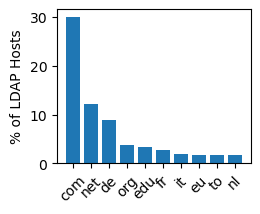

In [277]:
ldap_dns_pdf = pd.concat([pd.read_csv(filename) for filename in glob("../dataset/processing/censys_ldap_dns/*csv")])

top_tlds = ldap_dns_pdf.head(10)
fig, ax = plt.subplots(figsize=(2.5,2))
ax.set_xticks(range(len(top_tlds["fdns_tlds"])))
ax.set_xticklabels(top_tlds["fdns_tlds"], rotation=45) 
#plt.yticks(rotation=0)
ax.bar(top_tlds['fdns_tlds'], top_tlds['percentage'])
ax.set_ylabel('% of LDAP Hosts')
#ax.set_xlabel('TLD')
#ax.set_title('% of LDAP Hosts\nper TLD - CUIDS')
fig.savefig("output/ldap_tld.pdf", dpi=300, bbox_inches='tight')
fig.show()

### Country & Organizations

In [10]:
# not required
#censys_df.select("ipv4").toPandas().to_csv("../dataset/censys/processing/censys_ldap_ips.csv", index=False)

In [278]:
def country_org_stats(df, dataset):
    df.persist()

    print("Processing Country")
    country_pdf = df.groupBy("country").count().sort(psf.col("count").desc()).pandas_api()
    total = country_pdf["count"].sum()
    country_pdf["percentage"] = country_pdf["count"] / total * 100
    country_pdf.to_csv(f"../dataset/processing/{dataset}_country", index=False)

    print("Processing Org")
    org_pdf = df.groupBy("org").count().sort(psf.col("count").desc()).pandas_api()
    total = org_pdf["count"].sum()
    org_pdf["percentage"] = org_pdf["count"] / total * 100
    org_pdf.to_csv(f"../dataset/processing/{dataset}_org", index=False)

    df.unpersist()

In [280]:
print("Censys")
country_org_stats(censys_compact_df, "censys")
print("GoScanner")
country_org_stats(goscanner_df, "goscanner")

Censys


/usr/local/spark/python/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/spark/python/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


GoScanner


/usr/local/spark/python/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/spark/python/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Loading the saved data

In [185]:
censys_country_pdf = pd.concat([pd.read_csv(filename) for filename in glob("../dataset/processing/censys_country/*csv")])
censys_org_pdf = pd.concat([pd.read_csv(filename, quotechar='"') for filename in glob("../dataset/processing/censys_org/*csv")])
goscanner_country_pdf = pd.concat([pd.read_csv(filename) for filename in glob("../dataset/processing/goscanner_country/*csv")])
goscanner_org_pdf = pd.concat([pd.read_csv(filename) for filename in glob("../dataset/processing/goscanner_org/*csv")])

In [184]:
def see_unknown_org_cc(ccpdf, orgpdf):
    # ASN262726 at 20221101 does not give any country nor org name.
    # This ASN seems to be http://www.cortezonline.com.br (see https://www.ditatompel.com/asn/262726), https://bgp.he.net/AS262726
    # Some IPs do no have ASN
    # both cases we classified as Unknown
    aggr_country_pdf = ccpdf.groupby("country").sum().reset_index().sort_values("count", ascending=False)
    display(aggr_country_pdf[aggr_country_pdf["country"] == "Unknown"])

    aggr_org_pdf = orgpdf.groupby("org").sum().reset_index().sort_values("count", ascending=False)
    display(aggr_org_pdf[aggr_org_pdf["org"] == "Unknown"])


print("Censys")
see_unknown_org_cc(censys_country_pdf, censys_org_pdf)
print("GoScanner")
see_unknown_org_cc(goscanner_country_pdf, goscanner_org_pdf)

Censys


,country,count,percentage
191,Unknown,115,0.021156


,org,count,percentage
9052,Unknown,115,0.021156


GoScanner


,country,count,percentage
181,Unknown,1732,0.512356


,org,count,percentage
6336,Unknown,1732,0.512356


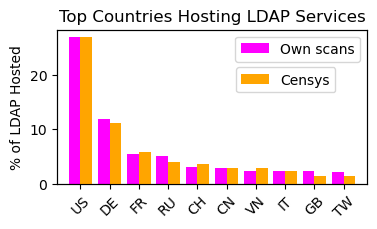

In [360]:
top_10cc_goscanner = goscanner_country_pdf.head(10)["country"].to_list()
censys_top_country = censys_country_pdf[censys_country_pdf["country"].isin(top_10cc_goscanner)]

fig, ax1 = plt.subplots(figsize=(4,2))
ax2 = ax1.twinx()
width = 0.4
p1 = goscanner_country_pdf.head(10).percentage.plot(kind='bar', color='magenta', ax=ax1, width=width, position=1, align='center')
p2 = censys_top_country.percentage.plot(kind='bar', color='orange', ax=ax2, width=width, position=0, align='center')
ax1.set_ylabel('% of LDAP Hosted')
ax1.set_title('Top Countries Hosting LDAP Services')
ax1.tick_params(axis='x', rotation=45)
margin = (1 - width) + width / 2
ax1.set_xlim(-margin, len(top_10cc_goscanner) - 1 + margin)
ax2.set_xlim(-margin, len(top_10cc_goscanner) - 1 + margin)
ax1.set_xticklabels(top_10cc_goscanner)
ax2.set_yticks([])
ax2.set_yticklabels([])
p1.legend(['Own scans'], bbox_to_anchor=(1.0, 1.0))
p2.legend(['Censys'], bbox_to_anchor=(0.92, 0.8))
fig.savefig("output/ldap_country.pdf", dpi=300, bbox_inches='tight')
fig.show()

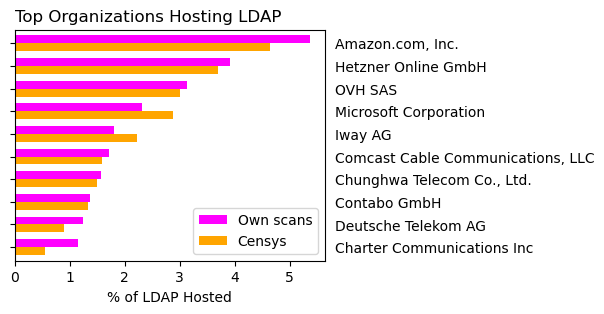

In [404]:
top_10org_goscanner = goscanner_org_pdf.head(10)["org"].to_list()
censys_top_org = censys_org_pdf[censys_org_pdf["org"].isin(top_10org_goscanner)]
top_org_pdf = pd.DataFrame({
        "Own scans": goscanner_org_pdf.head(10)["percentage"].to_list(),
        "Censys": censys_top_org["percentage"].to_list(), 
     }, index=top_10org_goscanner)

width = 0.7
ax1 = top_org_pdf.plot.barh(width=width, color=['magenta', 'orange'], figsize=(4,3))
ax1.invert_yaxis()
ax1.set_title('Top Organizations Hosting LDAP', loc='left')
ax1.tick_params(axis='y', labelright=True, labelleft=False)  
ax1.set_xlabel('% of LDAP Hosted')
fig = ax1.get_figure()
fig.savefig("output/ldap_org.pdf", dpi=300, bbox_inches='tight')
fig.show()

#### Org from perspective of country

In [ ]:
def get_org_in_cc_dict(df, dataset):
    cc_cnt_dict = defaultdict(int)
    for item in [v.dropna().to_dict() for k,v in censys_country_pdf.iterrows()]:
        try:
            cc_cnt_dict[item["country"]] += item["count"]
        except KeyError:
            # unknown country
            pass

def country_percentage(country, count):
    if country == "NaN":
        return 0
    return count / cc_cnt_dict[country] * 100

org_country_outsourced_pdf["percentage"] = org_country_outsourced_pdf[["country", "count"]].apply(lambda x: country_percentage(*x), axis=1)
display(org_country_outsourced_pdf.head(10))

### Outsourcing analysis

In [293]:
def method_1(leaf_cert_names, rdns_list, fdns_list):
#    varlist = [leaf_cert_names, rdns_list, fdns_list]
#    if rdns_list is not None and len(rdns_list) == 0:
#        x['r_dns_names'] = None
#    if fdns_list is not None and len(fdns_list) == 0:
#        x['dns_names'] = None

    # leaf_cert_names is a list of lists; hence, disentangle it
    flat_leaf_cert_names = []
    for lcn in leaf_cert_names:
        if lcn is not None:
            for name in lcn:
                flat_leaf_cert_names.append(name)

    leaf_cert_set = set(flat_leaf_cert_names) if flat_leaf_cert_names is not None else set()
    rdns_set = set(rdns_list) if rdns_list is not None else set()
    fdns_set = set(fdns_list) if fdns_list is not None else set()

    _x = leaf_cert_set
    _y = rdns_set.union(fdns_set)

    if len(_x) > 0:
        res_set_x = set()
        for item in _x:
            if item is None:
                continue
            extract = tldextract.extract(item)
            domain = extract.domain
            suffix = extract.suffix
            if domain != '' and suffix != '':
                sld_tld = f"{extract.domain}.{extract.suffix}"
                res_set_x.add(sld_tld)
        res_set_x = list(res_set_x) if len(res_set_x) > 0 else None
    else:
        res_set_x = None

    res_set_x = [item.lower() for item in res_set_x] if res_set_x is not None else None
    #x['x_set'] = res_set_x

    if len(_y) > 0:
        res_set_y = set()
        for item in _y:
            if item is None:
                continue
            extract = tldextract.extract(item)
            domain = extract.domain
            suffix = extract.suffix
            if domain != '' and suffix != '':
                sld_tld = f"{extract.domain}.{extract.suffix}"
                res_set_y.add(sld_tld)
        res_set_y = list(res_set_y) if len(res_set_y) > 0 else None
    else:
        res_set_y = None

    res_set_y = [item.lower() for item in res_set_y] if res_set_y is not None else None
    #x['y_set'] = res_set_y

    if res_set_y is not None and res_set_x is not None:
        len_set_x = len(res_set_x)
        counter = 0
        for item in res_set_x:
            if item in res_set_y:
                counter += 1
        outsourced = 'Outsource evidence' if counter != len_set_x else 'No outsource evidence'
        #x['outsourced_a'] = outsourced
    else:
        #x['outsourced_a'] = 'invalid'
        outsourced = 'Invalid'
    return outsourced


method_1_udf = psf.udf(method_1, pst.StringType())

In [294]:
def method_2(rdns_names, fdns_names):
    if rdns_names is None:
        rdns_list = None
    else:
        rdns_set = set()
        for item in rdns_names:
            if item is None:
                continue
            extract = tldextract.extract(item)
            domain = extract.domain
            suffix = extract.suffix
            if domain != '' and suffix != '':
                sld_tld = f"{extract.domain}.{extract.suffix}"
                rdns_set.add(sld_tld)
        rdns_list = list(rdns_set) if len(rdns_set) > 0 else None

    if fdns_names is None:
        fdns_list = None
        fdns_tld_list = None
    else:
        fdns_set = set()
        fdns_tld_set = set()
        for item in fdns_names:
            if item is None:
                continue
            extract = tldextract.extract(item)
            domain = extract.domain
            suffix = extract.suffix
            if domain != '' and suffix != '':
                sld_tld = f"{extract.domain}.{extract.suffix}"
                fdns_set.add(sld_tld)
                fdns_tld_set.add(extract.suffix)
        fdns_list = list(fdns_set) if len(fdns_set) > 0 else None
        fdns_tld_list = list(fdns_tld_set) if len(fdns_tld_set) > 0 else None

    rdns_list = [item.lower() for item in rdns_list] if rdns_list is not None else None
    fdns_list = [item.lower() for item in fdns_list] if fdns_list is not None else None  
    #x['rdns_domains'] = rdns_list # =: x
    #x['fdns_domains'] = fdns_list # =: y
    #x['fdns_tlds'] = fdns_tld_list

    outsourced = 'Invalid'
    if rdns_list is not None and fdns_list is not None:
        target = len(rdns_list)
        counter = 0
        for item in rdns_list:
            if item in fdns_list:
                counter += 1
        if target == counter:
            fdns_list = set(fdns_list)
            rdns_list = set(rdns_list)
            res = fdns_list - rdns_list
            if len(res) > 0:
                #x['outsourced_b'] = True
                outsourced = 'Outsource evidence'
            else:
                #x['outsourced_b'] = False
                outsourced = 'No outsource evidence'
        else:
            #x['outsourced_b'] = True
            outsourced = 'Outsource evidence'
    else:
        #x['outsourced_b'] = 'invalid'
        outsourced = 'Invalid'

    return outsourced


method_2_udf = psf.udf(method_2, pst.StringType())

In [295]:
censys_compact_df = censys_compact_df.withColumn("method_1", method_1_udf(psf.col("leaf_data_names"), psf.col("r_dns_names"), psf.col("dns_names")))
censys_compact_df = censys_compact_df.withColumn("method_2", method_2_udf(psf.col("r_dns_names"), psf.col("dns_names")))

In [296]:
m1_pdf = censys_compact_df.groupBy("method_1").count().to_pandas_on_spark()
m2_pdf = censys_compact_df.groupBy("method_2").count().to_pandas_on_spark()

/usr/local/spark/python/pyspark/sql/dataframe.py:5719: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(


In [297]:
print("Applicability")
m1_total = m1_pdf["count"].sum()
m1_pdf["percentage"] = m1_pdf["count"] / m1_total * 100
display(m1_pdf)
m2_total = m2_pdf["count"].sum()
m2_pdf["percentage"] = m2_pdf["count"] / m2_total * 100
display(m2_pdf)
print(m2_total)

assert m1_total == m2_total

Applicability


,method_1,count,percentage
0,Outsource evidence,91626,16.856184
1,No outsource evidence,185545,34.134204
2,Invalid,266404,49.009612


,method_2,count,percentage
0,Outsource evidence,111235,20.463597
1,No outsource evidence,173643,31.944626
2,Invalid,258697,47.591777


543575


#### Outsourcing from perspective of country

In [298]:
org_country_outsourced_pdf = censys_compact_df.filter((psf.col("method_1") == "Outsource evidence") | (psf.col("method_2") == "Outsource evidence")).groupBy(["org", "country"]).count().sort(psf.col("count").desc()).toPandas()

In [299]:
cc_cnt_dict = defaultdict(int)
for item in [v.dropna().to_dict() for k,v in censys_country_pdf.iterrows()]:
    try:
        cc_cnt_dict[item["country"]] += item["count"]
    except KeyError:
        # unknown country
        pass

def country_percentage(country, count):
    if country == "NaN":
        return 0
    return count / cc_cnt_dict[country] * 100

org_country_outsourced_pdf["percentage"] = org_country_outsourced_pdf[["country", "count"]].apply(lambda x: country_percentage(*x), axis=1)
display(org_country_outsourced_pdf.head(10))

,org,country,count,percentage
0,"Amazon.com, Inc.",US,12226,8.36
1,OVH SAS,FR,10522,33.07
2,Hetzner Online GmbH,DE,10059,16.55
3,home.pl S.A.,PL,8755,56.20
4,"Chunghwa Telecom Co., Ltd.",TW,5857,38.91
5,Contabo GmbH,DE,5129,8.44
6,"Comcast Cable Communications, LLC",US,3565,2.44
7,Deutsche Telekom AG,DE,2618,4.31
8,Charter Communications Inc,US,2314,1.58
9,Strato AG,DE,1866,3.07


In [300]:
print(cc_cnt_dict["US"], cc_cnt_dict["DE"], cc_cnt_dict["FR"], cc_cnt_dict["PL"], cc_cnt_dict["TW"])

146306 60797 31815 15578 15051


#### Outsourcing combined methods

In [301]:
_outs_censys_df = censys_compact_df.select("org", "tls_version", "tls_cipher", "tls_signature_self_signed", "method_1", "method_2")

In [302]:
df3 = _outs_censys_df.select("org", "method_1", "method_2",
                             psf.explode_outer(psf.arrays_zip(
                                                _outs_censys_df.tls_version,
                                                _outs_censys_df.tls_cipher,
                                                _outs_censys_df.tls_signature_self_signed)))
outs_censys_df = df3.select("org", "method_1", "method_2", "col.tls_version", "col.tls_cipher", "col.tls_signature_self_signed")
outs_censys_df.persist()

DataFrame[org: string, method_1: string, method_2: string, tls_version: string, tls_cipher: string, tls_signature_self_signed: boolean]

##### Oursource and self-signed

In [303]:
# by filtering not null, I'll get different percentages dictionary (see "lookout for discrepancies" below)
outs_censys_df.filter(psf.col("tls_signature_self_signed").isNotNull()) \
              .groupBy(["org", "tls_signature_self_signed"]) \
              .count() \
              .sort(psf.col("count").desc()) \
              .toPandas().to_csv("../dataset/processing/censys_org_ssign.csv")

In [220]:
org_ssign_pdf = pd.read_csv("../dataset/processing/censys_org_ssign.csv", index_col=0)

org_ssign_cnt_dict = defaultdict(int)
for item in [v.dropna().to_dict() for k,v in org_ssign_pdf.iterrows()]:
    try:
        org_ssign_cnt_dict[item["org"]] += item["count"]
    except KeyError:
        # unknown country
        pass

def org_ssign_percentage(org, count):
    if not isinstance(org, str) and math.isnan(org):
        return 0
    return round(count / org_ssign_cnt_dict[org] * 100, 2)

org_ssign_pdf["percentage"] = org_ssign_pdf[["org", "count"]].apply(lambda x: org_ssign_percentage(*x), axis=1)
display(org_ssign_pdf[org_ssign_pdf["tls_signature_self_signed"] == True].sort_values("count", ascending=False).head(10))

,org,tls_signature_self_signed,count,percentage
6,OVH SAS,True,22742,23.37
8,"Chunghwa Telecom Co., Ltd.",True,19922,25.78
9,Hetzner Online GmbH,True,17448,17.70
12,Shenzhen Tencent Computer Systems Company Limited,True,15683,86.31
18,Contabo GmbH,True,11616,26.67
21,Microsoft Corporation,True,10267,45.08
24,"Amazon.com, Inc.",True,9506,25.90
25,"No.31,Jin-rong Street",True,9470,47.27
27,Deutsche Telekom AG,True,9096,35.03
29,"Comcast Cable Communications, LLC",True,7997,34.03


##### Data preparation

In [167]:
# TODO
outs_censys_df.filter(psf.col("tls_cipher").isNotNull()) \
              .select(["org", "tls_cipher", "tls_version", "method_1", "method_2"]) \
              .to_pandas_on_spark() \
              .dropna(subset=["tls_cipher"], inplace=True) \
              .apply(parse_tls_cipher, axis=1) \
              .toPandas().to_csv("../dataset/censys/processing/censys_org_tls_outs.csv")

In [168]:
try:
    org_tls_outs_pdf
except:
    org_tls_outs_pdf = pd.read_csv("../dataset/censys/processing/censys_org_tls_outs.csv", index_col=0)

org_tls_outs_pdf.dropna(subset=["tls_cipher"], inplace=True)
org_tls_outs_pdf = org_tls_outs_pdf.apply(parse_tls_cipher, axis=1)

In [170]:
org_tls_outs_pdf.to_csv("../dataset/censys/processing/censys_org_tls_outs.csv")

In [195]:
try:
    org_tls_outs_pdf
except:
    org_tls_outs_pdf = pd.read_csv("../dataset/censys/processing/censys_org_tls_outs.csv", index_col=0)

def combined_methods(method1, method2):
    if method1 == "Outsource evidence" or method2 == "Outsource evidence":
        return True
    return False

def tls_version_weak(tls_version):
    if tls_version == "TLSv1_0" or tls_version == "TLSv1_1":
        return True
    return False

org_tls_outs_pdf["combined"] = org_tls_outs_pdf[['method_1', 'method_2']].apply(lambda x: combined_methods(*x), axis=1)
org_tls_outs_pdf["tls_version_weak"] = org_tls_outs_pdf["tls_version"].apply(tls_version_weak)

In [210]:
aggr_org_outs_pdf = org_tls_outs_pdf.groupby(["org", "combined"]).size().reset_index(name="count").sort_values("count", ascending=False)
org_outs_cnt_dict = defaultdict(int)
for item in [v.dropna().to_dict() for k,v in aggr_org_outs_pdf.iterrows()]:
    try:
        org_outs_cnt_dict[item["org"]] += item["count"]
    except KeyError:
        # unknown country
        pass

def org_outs_percentage(org, count):
    if not isinstance(org, str) and math.isnan(org):
        return 0
    return round(count / org_outs_cnt_dict[org] * 100, 2)

aggr_org_outs_pdf["percentage"] = aggr_org_outs_pdf[["org", "count"]].apply(lambda x: org_outs_percentage(*x), axis=1)

In [211]:
display(aggr_org_outs_pdf[aggr_org_outs_pdf["combined"] == True].sort_values("count", ascending=False).head(10))

,org,combined,count,percentage
4343,Hetzner Online GmbH,True,64103,65.04
7603,OVH SAS,True,58673,60.29
12495,home.pl S.A.,True,53235,97.02
1941,"Chunghwa Telecom Co., Ltd.",True,42867,55.47
2269,Contabo GmbH,True,27500,63.13
699,"Amazon.com, Inc.",True,25366,69.11
12579,netcup GmbH,True,13466,73.76
2759,Deutsche Telekom AG,True,13463,51.85
2146,"Comcast Cable Communications, LLC",True,13346,56.79
6087,"Linode, LLC",True,10469,68.36


In [224]:
print(org_outs_cnt_dict["Amazon.com, Inc."], org_outs_cnt_dict["OVH SAS"], org_outs_cnt_dict["Hetzner Online GmbH"])

36706 97321 98558


##### Outsource, weak cipher and weak TLS version

In [200]:
aggr_org_tls_cipher_outs_pdf = org_tls_outs_pdf.groupby(["org", "combined", "cipher_weak", "tls_version_weak"]).size().reset_index(name="count").sort_values("count", ascending=False)
org_tls_cipher_outs_cnt_dict = defaultdict(int)
for item in [v.dropna().to_dict() for k,v in aggr_org_tls_cipher_outs_pdf.iterrows()]:
    try:
        org_tls_cipher_outs_cnt_dict[item["org"]] += item["count"]
    except KeyError:
        # unknown country
        pass

def org_tls_cipher_outs_percentage(org, count):
    if not isinstance(org, str) and math.isnan(org):
        return 0
    return round(count / org_tls_cipher_outs_cnt_dict[org] * 100, 2)

aggr_org_tls_cipher_outs_pdf["percentage"] = aggr_org_tls_cipher_outs_pdf[["org", "count"]].apply(lambda x: org_tls_cipher_outs_percentage(*x), axis=1)

In [228]:
tmp = aggr_org_tls_cipher_outs_pdf[(aggr_org_tls_cipher_outs_pdf["combined"] == True) & (aggr_org_tls_cipher_outs_pdf["cipher_weak"] == True) & (aggr_org_tls_cipher_outs_pdf["tls_version_weak"] == True)]
display(tmp[(tmp["org"] == "Amazon.com, Inc.") | (tmp["org"] == "Hetzner Online GmbH") | (tmp["org"] == "OVH SAS")])
display(tmp.sort_values(["count", "percentage"], ascending=False).head(10))

,org,combined,cipher_weak,tls_version_weak,count,percentage
7311,Hetzner Online GmbH,True,True,True,1263,1.28
12760,OVH SAS,True,True,True,1157,1.19
1131,"Amazon.com, Inc.",True,True,True,204,0.56


,org,combined,cipher_weak,tls_version_weak,count,percentage
16402,Six Degrees Technology Group Limited,True,True,True,5150,34.16
3273,"Chunghwa Telecom Co., Ltd.",True,True,True,3155,4.08
3642,"Comcast Cable Communications, LLC",True,True,True,1359,5.78
7311,Hetzner Online GmbH,True,True,True,1263,1.28
1758,"Badger Internet, Inc.",True,True,True,1258,59.90
12760,OVH SAS,True,True,True,1157,1.19
7953,IP worldcom SA,True,True,True,864,41.68
3162,Charter Communications Inc,True,True,True,829,5.02
12318,"No.31,Jin-rong Street",True,True,True,622,3.11
3987,Cox Communications Inc.,True,True,True,467,8.75


##### Outsource and weak cipher

In [ ]:
aggr_org_cipher_outs_pdf = org_tls_outs_pdf.groupby(["org", "combined", "cipher_weak"]).size().reset_index(name="count").sort_values("count", ascending=False)

org_cipher_outs_cnt_dict = defaultdict(int)
for item in [v.dropna().to_dict() for k,v in aggr_org_cipher_outs_pdf.iterrows()]:
    try:
        org_cipher_outs_cnt_dict[item["org"]] += item["count"]
    except KeyError:
        # unknown country
        pass

def org_cipher_outs_percentage(org, count):
    if not isinstance(org, str) and math.isnan(org):
        return 0
    return round(count / org_cipher_outs_cnt_dict[org] * 100, 2)

aggr_org_cipher_outs_pdf["percentage"] = aggr_org_cipher_outs_pdf[["org", "count"]].apply(lambda x: org_cipher_outs_percentage(*x), axis=1)

In [185]:
display(aggr_org_cipher_outs_pdf[(aggr_org_cipher_outs_pdf["combined"] == True) & (aggr_org_cipher_outs_pdf["cipher_weak"] == True)].sort_values("count", ascending=False).head(10))

,org,combined,cipher_weak,count,percentage
2942,"Chunghwa Telecom Co., Ltd.",True,True,12368,16.00
11463,OVH SAS,True,True,7389,7.59
14764,Six Degrees Technology Group Limited,True,True,6080,40.33
6569,Hetzner Online GmbH,True,True,5329,5.41
3268,"Comcast Cable Communications, LLC",True,True,4186,17.81
1043,"Amazon.com, Inc.",True,True,3297,8.98
3451,Contabo GmbH,True,True,2824,6.48
2850,Charter Communications Inc,True,True,2229,13.50
1162,Aptum Technologies,True,True,1895,61.09
9995,Microsoft Corporation,True,True,1559,6.85


##### Outsource and weak TLS version

In [196]:
aggr_org_tls_outs_pdf = org_tls_outs_pdf.groupby(["org", "combined", "tls_version_weak"]).size().reset_index(name="count").sort_values("count", ascending=False)

org_tls_outs_cnt_dict = defaultdict(int)
for item in [v.dropna().to_dict() for k,v in aggr_org_tls_outs_pdf.iterrows()]:
    try:
        org_tls_outs_cnt_dict[item["org"]] += item["count"]
    except KeyError:
        # unknown country
        pass

def org_tls_outs_percentage(org, count):
    if not isinstance(org, str) and math.isnan(org):
        return 0
    return round(count / org_tls_outs_cnt_dict[org] * 100, 2)

aggr_org_tls_outs_pdf["percentage"] = aggr_org_tls_outs_pdf[["org", "count"]].apply(lambda x: org_tls_outs_percentage(*x), axis=1)

In [230]:
tmp = aggr_org_tls_outs_pdf[(aggr_org_tls_outs_pdf["combined"] == True) & (aggr_org_tls_outs_pdf["tls_version_weak"] == True)]
display(tmp[(tmp["org"] == "Amazon.com, Inc.") | (tmp["org"] == "Hetzner Online GmbH") | (tmp["org"] == "OVH SAS")])
display(tmp.sort_values(["count", "percentage"], ascending=False).head(10))

,org,combined,tls_version_weak,count,percentage
5290,Hetzner Online GmbH,True,True,1263,1.28
9254,OVH SAS,True,True,1157,1.19
818,"Amazon.com, Inc.",True,True,204,0.56


,org,combined,tls_version_weak,count,percentage
11900,Six Degrees Technology Group Limited,True,True,5150,34.16
2360,"Chunghwa Telecom Co., Ltd.",True,True,3155,4.08
2619,"Comcast Cable Communications, LLC",True,True,1359,5.78
5290,Hetzner Online GmbH,True,True,1263,1.28
1284,"Badger Internet, Inc.",True,True,1258,59.90
9254,OVH SAS,True,True,1157,1.19
5750,IP worldcom SA,True,True,864,41.68
2282,Charter Communications Inc,True,True,829,5.02
8931,"No.31,Jin-rong Street",True,True,622,3.11
2868,Cox Communications Inc.,True,True,467,8.75


##### lookout for discrepancies

In [204]:
print(org_tls_outs_cnt_dict == org_ssign_cnt_dict)
print(org_tls_outs_cnt_dict == org_tls_cipher_outs_cnt_dict)
for k,v in org_tls_outs_cnt_dict.items():
    try:
        if v != org_ssign_cnt_dict[k]:
            print(k, v, org_ssign_cnt_dict[k])
    except:
        print(k, v, org_ssign_cnt_dict[k])


False
True
OVH SAS 97321 97316
Amazon.com, Inc. 36706 36699
netcup GmbH 18257 18199
Hostway Deutschland GmbH 270 247
Envia Tel GmbH 179 159
